In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.3 MB/s eta 0:00:00


In [3]:
import os
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
import concurrent.futures
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
from tensorflow.keras.models import load_model, save_model



<ipython-input-3-434ea345e084>:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [4]:
# Data main directory
data_dir = "/content/drive/MyDrive/data"

subdirectories = ["train", "val", "test"]

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

train_good = [os.path.join(data_dir, sub, "Good", img) for sub in subdirectories for img in os.listdir(os.path.join(data_dir, sub, "Good")) if img.startswith(sub)]
val_good = [os.path.join(data_dir, sub, "Good", img) for sub in subdirectories for img in os.listdir(os.path.join(data_dir, sub, "Good")) if img.startswith(sub)]
test_good = [os.path.join(data_dir, sub, "Good", img) for sub in subdirectories for img in os.listdir(os.path.join(data_dir, sub, "Good")) if img.startswith(sub)]

train_bad = [os.path.join(data_dir, sub, "Bad", img) for sub in subdirectories for img in os.listdir(os.path.join(data_dir, sub, "Bad")) if img.startswith(sub)]
val_bad = [os.path.join(data_dir, sub, "Bad", img) for sub in subdirectories for img in os.listdir(os.path.join(data_dir, sub, "Bad")) if img.startswith(sub)]
test_bad = [os.path.join(data_dir, sub, "Bad", img) for sub in subdirectories for img in os.listdir(os.path.join(data_dir, sub, "Bad")) if img.startswith(sub)]


In [5]:

# Load and preprocess image
def load_and_preprocess_image(img_path, target_size=(299, 299)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    return preprocess_input(img_array)

def copy_and_resize(images, label, dest_dir, target_size=(299, 299)):
    os.makedirs(os.path.join(dest_dir, label), exist_ok=True)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        img_arrays = list(executor.map(load_and_preprocess_image, images))

    for img_path, img_array in zip(images, img_arrays):
        img_name = os.path.basename(img_path)
        output_path = os.path.join(dest_dir, label, img_name)
        save_img(output_path, img_array)

# copy and resize images
copy_and_resize(train_good, "Good", train_dir)
copy_and_resize(val_good, "Good", val_dir)
copy_and_resize(test_good, "Good", test_dir)


copy_and_resize(train_bad, "Bad", train_dir)
copy_and_resize(val_bad, "Bad", val_dir)
copy_and_resize(test_bad, "Bad", test_dir)

# Data augumentation for train set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalization
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# image generators for train and test sets
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0).flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0).flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

y_test = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    y_test.extend(labels)

y_test = np.array(y_test)



Found 1536 images belonging to 2 classes.
Found 512 images belonging to 2 classes.
Found 512 images belonging to 2 classes.


In [6]:
def create_inceptionv3_model(input_shape=(299, 299, 3), num_classes=1):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    predictions = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [17]:


def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.show()

def train_model(model, train_generator, val_generator, epochs=10):
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    validation_steps = val_generator.samples // val_generator.batch_size

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps
    )
    plot_training_history(history)

    y_train = train_generator.classes
    y_train_pred = model.predict(train_generator, steps=steps_per_epoch)
    y_val = val_generator.classes
    y_val_pred = model.predict(val_generator, steps=validation_steps)

    train_metrics = calculate_metrics(y_train, np.round(y_train_pred))
    val_metrics = calculate_metrics(y_val, np.round(y_val_pred))

    return train_metrics, val_metrics

def test_model(model, test_generator, threshold=0.5):
    steps = test_generator.samples // test_generator.batch_size

    y_test = test_generator.classes
    y_test_pred = model.predict(test_generator, steps=steps)

    cm = confusion_matrix(y_test, np.round(y_test_pred))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    test_metrics = calculate_metrics(y_test, np.round(y_test_pred))

    return test_metrics


def calculate_metrics(y_true, y_pred):
    precision = Precision()(y_true, y_pred)
    recall = Recall()(y_true, y_pred)

    auc = AUC()(y_true, y_pred)

    metrics_result = {
        'Precision': precision,
        'Recall': recall,
        'AUC': auc
    }

    for metric_name, metric_value in metrics_result.items():
        print(f'{metric_name}: {metric_value.numpy():.4f}')

    return metrics_result



In [8]:
model = create_inceptionv3_model()

learning_rate = 0.005
# Compilar el modelo con la métrica personalizada
model.compile(
    optimizer=Adam(learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps
)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
24/24 [==============================] - 616s 25s/step - loss: 0.5579 - accuracy: 0.7031 - auc: 0.7817 - precision: 0.7047 - recall: 0.6992 - val_loss: 0.7941 - val_accuracy: 0.5957 - val_auc: 0.5838 - val_precision: 0.5727 - val_recall: 0.7539
Epoch 2/10
24/24 [==============================] - 102s 4s/step - loss: 0.4414 - accuracy: 0.7982 - auc: 0.8768 - precision: 0.8111 - recall: 0.7773 - val_loss: 0.8828 - val_accuracy: 0.6055 - val_auc: 0.6306 - val_precision: 0.5659 - val_recall: 0.9062
Epoch 3/10
24/24 [==============================] - 101s 4s/step - loss: 0.4041 - accuracy: 0.8112 - auc: 0.9011 - precision: 0.8283 - recall: 0.7852 - val_loss: 0.7747 - val_accuracy: 0.6484 - val_auc: 0.6562 - val_precision: 0.6131 - val_recall: 0.8047
Epoch 4/10
24/24 [==============================] - 102s 4s/step - loss: 0.4056 - accuracy: 0.8223 - auc: 0.9002 - precision: 0.8377 - recall: 0.7995 - val_loss: 0.7591 

8/8 [==============================] - 15s 2s/step


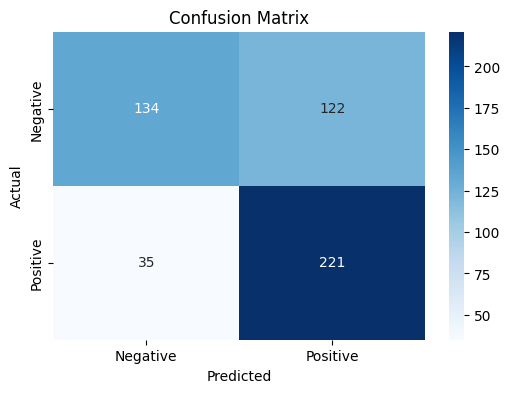

Precision: 0.6443
Recall: 0.8633
AUC: 0.6934

Test set metrics:
{'Precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.6443149>, 'Recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.86328125>, 'AUC': <tf.Tensor: shape=(), dtype=float32, numpy=0.6933594>}


In [9]:
test_metrics = test_model(model, test_generator)

print("\nTest set metrics:")
print(test_metrics)

Epoch 1/10
24/24 [==============================] - 105s 4s/step - loss: 0.3118 - accuracy: 0.8757 - auc: 0.9435 - precision: 0.8732 - recall: 0.8789 - val_loss: 0.8717 - val_accuracy: 0.6484 - val_auc: 0.6989 - val_precision: 0.5979 - val_recall: 0.9062
Epoch 2/10
24/24 [==============================] - 101s 4s/step - loss: 0.3097 - accuracy: 0.8770 - auc: 0.9434 - precision: 0.8755 - recall: 0.8789 - val_loss: 0.8850 - val_accuracy: 0.6504 - val_auc: 0.6936 - val_precision: 0.6005 - val_recall: 0.8984
Epoch 3/10
24/24 [==============================] - 103s 4s/step - loss: 0.3027 - accuracy: 0.8691 - auc: 0.9465 - precision: 0.8716 - recall: 0.8659 - val_loss: 0.8453 - val_accuracy: 0.6562 - val_auc: 0.6884 - val_precision: 0.6183 - val_recall: 0.8164
Epoch 4/10
24/24 [==============================] - 101s 4s/step - loss: 0.2887 - accuracy: 0.8828 - auc: 0.9518 - precision: 0.8838 - recall: 0.8815 - val_loss: 0.9870 - val_accuracy: 0.6309 - val_auc: 0.6905 - val_precision: 0.5827 -

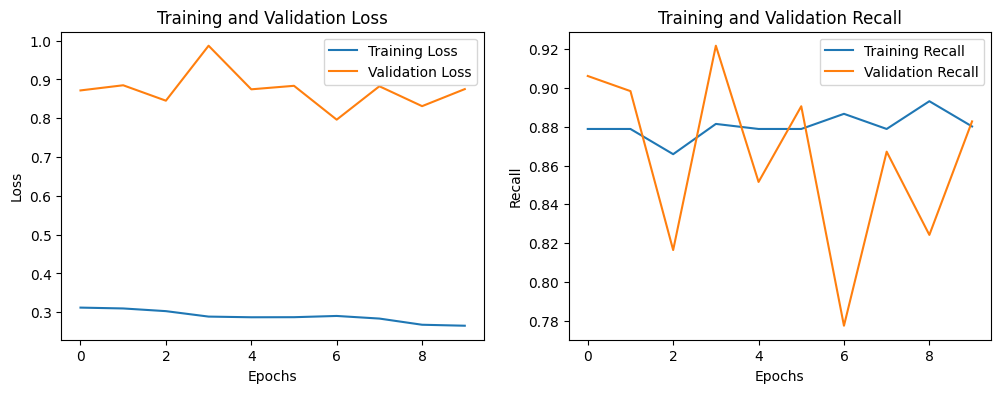

8/8 [==============================] - 18s 2s/step
Precision: 0.5046
Recall: 0.5013
AUC: 0.5046
Precision: 0.5054
Recall: 0.7344
AUC: 0.5078
Training set metrics:
{'Precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.5045872>, 'Recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.50130206>, 'AUC': <tf.Tensor: shape=(), dtype=float32, numpy=0.50455725>}

Validation set metrics:
{'Precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.50537634>, 'Recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.734375>, 'AUC': <tf.Tensor: shape=(), dtype=float32, numpy=0.5078125>}
8/8 [==============================] - 13s 2s/step


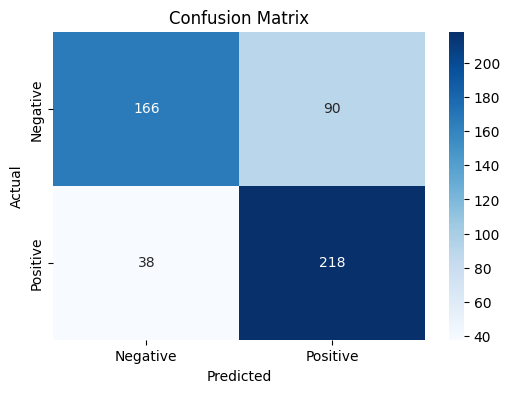

Precision: 0.7078
Recall: 0.8516
AUC: 0.7500

Test set metrics:
{'Precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.7077922>, 'Recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.8515625>, 'AUC': <tf.Tensor: shape=(), dtype=float32, numpy=0.75>}


In [10]:
train_metrics, val_metrics = train_model(model, train_generator, val_generator, epochs=10)

print("Training set metrics:")
print(train_metrics)

print("\nValidation set metrics:")
print(val_metrics)

test_metrics = test_model(model, test_generator)

print("\nTest set metrics:")
print(test_metrics)

In [11]:
def build_model(hp):
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units', min_value=32, max_value=512, step=96), activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[ 1e-3, 5e-3])),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

    return model

In [12]:
from kerastuner import Objective

steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

tuner = RandomSearch(
    build_model,
    objective=Objective('val_precision', direction='max'),
    max_trials=3,
    executions_per_trial=2,
    directory='random_search',
    project_name='InceptionV3'
)

tuner.search(train_generator,
             steps_per_epoch=steps_per_epoch,
             epochs=5,
             validation_data=val_generator,
             validation_steps=validation_steps)

Trial 3 Complete [00h 21m 40s]
val_precision: 0.6182260811328888

Best val_precision So Far: 0.6182260811328888
Total elapsed time: 01h 03m 28s


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters

8/8 [==============================] - 17s 2s/step


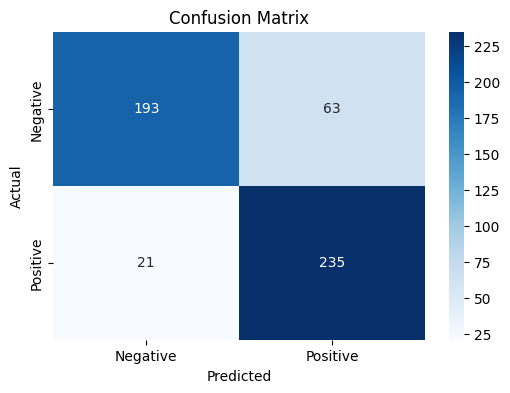

Precision: 0.7886
Recall: 0.9180
AUC: 0.8359

Test set metrics:
{'Precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.7885906>, 'Recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.91796875>, 'AUC': <tf.Tensor: shape=(), dtype=float32, numpy=0.8359375>}


In [15]:
test_metrics = test_model(best_model, test_generator)

print("\nTest set metrics:")
print(test_metrics)

8/8 [==============================] - 13s 2s/step


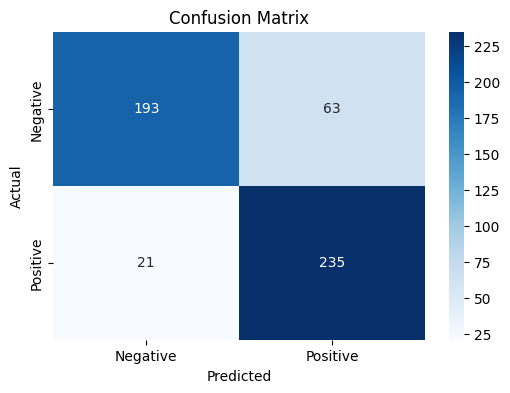

Precision: 0.7886
Recall: 0.9180
AUC: 0.8359

Test set metrics with threshold 0.6:
{'Precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.7885906>, 'Recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.91796875>, 'AUC': <tf.Tensor: shape=(), dtype=float32, numpy=0.8359375>}


In [23]:
prob_predictions = best_model.predict(test_generator)

new_threshold = 0.6

new_predictions = (prob_predictions > new_threshold).astype(int)

new_metrics = test_model(best_model, test_generator, threshold=new_threshold)

print(f"\nTest set metrics with threshold {new_threshold}:")
print(new_metrics)
